# Flower Classification Model

In [26]:
import matplotlib.pyplot as plt

import numpy as np

import os

from PIL import Image

import tensorflow as tf

In [27]:
categories = sorted(os.listdir("./data/flowers/train"))

print("--------------------------------------------------")
print("CATEGORIES")
print("--------------------------------------------------")
for category in categories:
    print(category)
print("--------------------------------------------------")

--------------------------------------------------
CATEGORIES
--------------------------------------------------
daisy
dandelion
rose
sunflower
tulip
--------------------------------------------------


In [28]:
IMAGE_SIZE = 64
PADDING_COLOR = (0, 0, 0)


def load_image(path):
    image = Image.open(path)
    ratio = image.size[0] / image.size[1]
    size = (
        (IMAGE_SIZE, 2 * round(IMAGE_SIZE / ratio / 2))
        if ratio > 1
        else (2 * round(IMAGE_SIZE * ratio / 2), IMAGE_SIZE)
    )
    left = round((IMAGE_SIZE - size[0]) / 2)
    top = round((IMAGE_SIZE - size[1]) / 2)
    new_image = Image.new(image.mode, (IMAGE_SIZE, IMAGE_SIZE), PADDING_COLOR)
    new_image.paste(image.resize(size), (left, top))
    return np.array(new_image)

In [29]:
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []
y_test = []

TRAIN_DIR = "./data/flowers/train/"
SPLIT_THRESHOLDS = (0.7, 0.85, 1)

for category_index, category in enumerate(categories):
    files = os.listdir(TRAIN_DIR + category)
    n_files = len(files)
    for file_index, file in enumerate(files):
        image = load_image(TRAIN_DIR + category + "/" + file)
        label = category_index
        if file_index < SPLIT_THRESHOLDS[0] * n_files:
            X_train.append(image)
            y_train.append(label)
        elif file_index < SPLIT_THRESHOLDS[1] * n_files:
            X_valid.append(image)
            y_valid.append(label)
        else:
            X_test.append(image)
            y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("--------------------------------------------------")
print("DATA")
print("--------------------------------------------------")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"y_valid: {y_valid.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print("--------------------------------------------------")

--------------------------------------------------
DATA
--------------------------------------------------
X_train: (1924, 64, 64, 3)
y_train: (1924,)
X_valid: (412, 64, 64, 3)
y_valid: (412,)
X_test: (410, 64, 64, 3)
y_test: (410,)
--------------------------------------------------


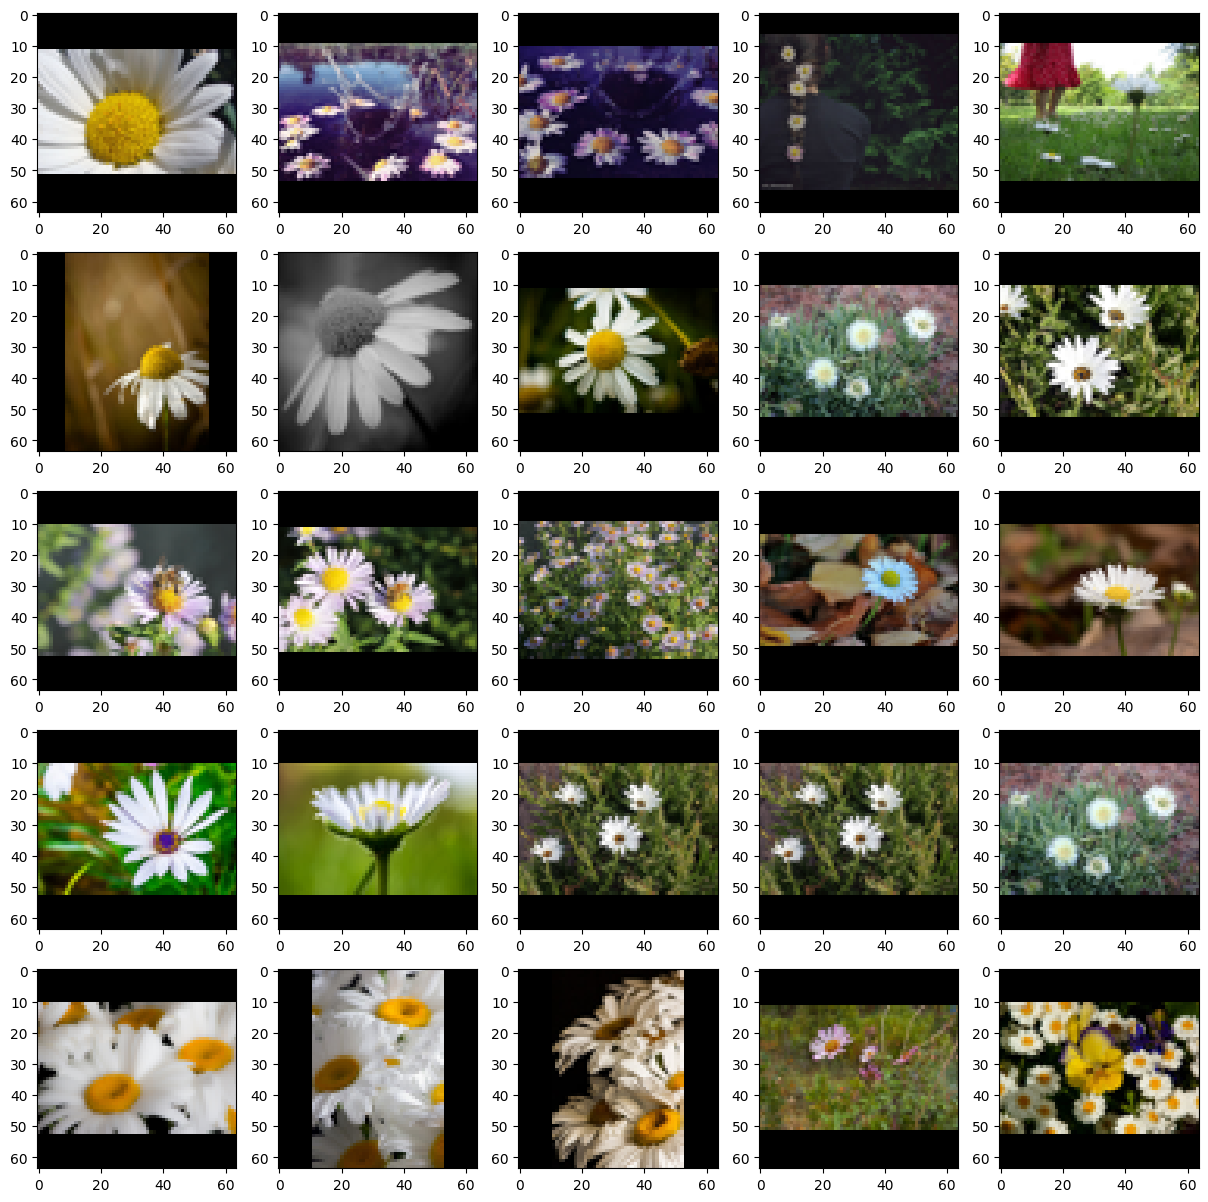

In [30]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(15, 15)
axes = axes.flatten()

for index, image in enumerate(X_train[:25]):
    ax = axes[index]
    ax = ax.imshow(image)

In [31]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = 10

ds_train = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .cache()
    .batch(BATCH_SIZE)
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

ds_valid = (
    tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    .cache()
    .batch(BATCH_SIZE)
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

ds_test = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .cache()
    .batch(BATCH_SIZE)
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

In [32]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(
            scale=1 / 255,
            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
            name="rescaling",
        ),
        tf.keras.layers.RandomFlip(
            mode="horizontal_and_vertical",
        ),
        tf.keras.layers.RandomRotation(
            factor=(-1, 1),
            fill_mode="reflect",
        ),
        tf.keras.layers.RandomZoom(
            height_factor=(-0.25, 0.25),
            width_factor=None,
            fill_mode="reflect",
        ),
        tf.keras.layers.Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="convolution_1",
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=2,
            strides=2,
            padding="valid",
            name="pooling_1",
        ),
        tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="convolution_2",
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=2,
            strides=2,
            padding="valid",
            name="pooling_2",
        ),
        tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
            name="convolution_3",
        ),
        tf.keras.layers.MaxPooling2D(
            pool_size=2,
            strides=2,
            padding="valid",
            name="pooling_3",
        ),
        tf.keras.layers.Dropout(
            rate=0.2,
        ),
        tf.keras.layers.Flatten(
            name="flatten_1",
        ),
        tf.keras.layers.Dense(
            units=128,
            activation="relu",
            name="dense_1",
        ),
        tf.keras.layers.Dense(
            units=len(categories),
            name="output",
        ),
    ],
    name="model",
)

model_optimizer = tf.keras.optimizers.Adam()
model_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_metric = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(model_optimizer, model_loss, model_metric)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_rotation_5 (RandomR  (None, 64, 64, 3)         0         
 otation)                                                        
                                                                 
 random_zoom_5 (RandomZoom)  (None, 64, 64, 3)         0         
                                                                 
 convolution_1 (Conv2D)      (None, 64, 64, 16)        448       
                                                                 
 pooling_1 (MaxPooling2D)    (None, 32, 32, 16)        0         
                                                             

In [33]:
MODEL_EPOCHS = 64

model_history = model.fit(ds_train, validation_data=ds_valid, epochs=MODEL_EPOCHS)

Epoch 1/64
31/31 [==============================] - 4s 90ms/step - loss: 1.7844 - sparse_categorical_accuracy: 0.1772 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.2282
Epoch 2/64
31/31 [==============================] - 3s 84ms/step - loss: 1.6122 - sparse_categorical_accuracy: 0.1273 - val_loss: 1.6087 - val_sparse_categorical_accuracy: 0.2136
Epoch 3/64
31/31 [==============================] - 3s 92ms/step - loss: 1.6156 - sparse_categorical_accuracy: 0.1689 - val_loss: 1.6029 - val_sparse_categorical_accuracy: 0.2209
Epoch 4/64
31/31 [==============================] - 3s 111ms/step - loss: 1.6101 - sparse_categorical_accuracy: 0.2095 - val_loss: 1.6080 - val_sparse_categorical_accuracy: 0.2209
Epoch 5/64
31/31 [==============================] - 3s 110ms/step - loss: 1.6082 - sparse_categorical_accuracy: 0.1965 - val_loss: 1.6065 - val_sparse_categorical_accuracy: 0.2257
Epoch 6/64
31/31 [==============================] - 3s 109ms/step - loss: 1.6074 - sparse_categorical_a

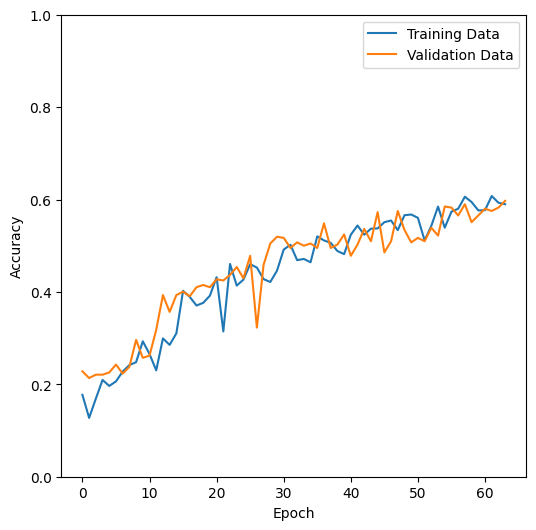

In [34]:
train_accuracy = model_history.history["sparse_categorical_accuracy"]
valid_accuracy = model_history.history["val_sparse_categorical_accuracy"]

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot(range(len(train_accuracy)), train_accuracy, label="Training Data")
ax.plot(range(len(valid_accuracy)), valid_accuracy, label="Validation Data")
ax.set_ylim(0, 1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()